## **IMPORTAÇÃO DAS BIBLIOTECAS**

Nesta etapa, importei as bibliotecas necessárias para:
- Manipular dados (`pandas`, `numpy`);
- Processar texto (`nltk`, `re`);
- Calcular TF-IDF e similaridade de cosseno (`scikit-learn`).

Também baixei os recursos do NLTK (tokenizador e stopwords).

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## **CARREGAMENTO DO DATASET**

Carreguei o dataset contendo artigos científicos.  
Este dataset possui as colunas **TITLE** e **ABSTRACT**, que representam o título e o resumo de cada artigo.  
Em seguida, criei uma nova coluna chamada `TEXT`, que une ambas as informações — isso aumenta o contexto disponível para o cálculo de similaridade.

In [2]:
df1 = pd.read_csv('train.csv', engine='python', on_bad_lines='warn')
df2 = pd.read_csv('test.csv', engine='python', on_bad_lines='warn')
df = pd.concat([df1, df2])

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 29961 entries, 0 to 8988
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    29961 non-null  int64  
 1   TITLE                 29961 non-null  object 
 2   ABSTRACT              29961 non-null  object 
 3   Computer Science      20972 non-null  float64
 4   Physics               20972 non-null  float64
 5   Mathematics           20972 non-null  float64
 6   Statistics            20972 non-null  float64
 7   Quantitative Biology  20972 non-null  float64
 8   Quantitative Finance  20972 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.3+ MB


In [4]:
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1.0,0.0,0.0,0.0,0.0,0.0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1.0,0.0,0.0,0.0,0.0,0.0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0.0,0.0,1.0,0.0,0.0,0.0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0.0,0.0,1.0,0.0,0.0,0.0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
df = df[['TITLE', 'ABSTRACT']]
df['TEXT'] = df['TITLE'] + ' ' + df['ABSTRACT']

## **PRÉ-PROCESSAMENTO DE TEXTO**

Nesta etapa, apliquei transformações para **limpar e normalizar** os textos, facilitando o cálculo de similaridade.

As etapas do pré-processamento são:
1. **Lowercasing:** transforma todas as letras em minúsculas.  
2. **Remoção de pontuação:** remove caracteres especiais, **mas mantém hífen** (`-`).  
3. **Tokenização:** divide o texto em palavras (tokens).  
4. **Remoção de stopwords:** elimina palavras comuns (como “the”, “and”, “of”).  
5. **Stemming:** reduz palavras à sua forma base (exemplo: *running → run*, *studies → studi*).  

O *stemming* ajuda a tratar diferentes variações de uma palavra como equivalentes, reduzindo a dimensionalidade do texto.

In [6]:
def preprocess_text(text):
    # lowercase
    text = text.lower()

    # remover pontuação(exceto hífen) e remover espaços extras
    text = re.sub(r'[^\w\s-]', '', text)
    text = text.strip()

    # tokenização
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)

    # remover stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # stemming
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]

    # juntar tudo de novo
    return ' '.join(tokens)

## **APLICANDO O PRÉ-PROCESSAMENTO**

Aqui apliquei a função `preprocess_text` a cada artigo do dataset.  


In [7]:
df['CLEAN_TEXT'] = df['TEXT'].apply(preprocess_text)

In [8]:
df['CLEAN_TEXT'].head()

,CLEAN_TEXT
0,reconstruct subject-specif effect map predict ...
1,rotat invari neural network rotat invari trans...
2,spheric polyharmon poisson kernel polyharmon f...
3,finit element approxim stochast maxwel -- land...
4,compar studi discret wavelet transform wavelet...


## **CÁLCULO DA MATRIZ TF-IDF**

Após o pré-processamento, aplicamos o **TF-IDF (Term Frequency–Inverse Document Frequency)**.

Esse método transforma cada documento em um vetor numérico, onde:
- Cada posição representa uma palavra do vocabulário;
- O valor indica o quanto essa palavra é relevante no documento (frequente no documento, mas rara nos demais).

Com isso, podemos calcular **semelhança entre documentos** com base na angulação entre esses vetores.

In [9]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['CLEAN_TEXT'])

In [10]:
tfidf_matrix.shape

(29961, 72659)

##  **FUNÇÃO DE BUSCA DE ARTIGOS COM TF-IDF E VISUALIZAÇÃO 3D**

Esta função realiza uma busca de artigos com base em uma **query do usuário**, utilizando **TF-IDF** para representar os textos e **similaridade do cosseno** para medir a proximidade entre a query e os artigos do dataset. Além disso, gera uma **visualização 3D interativa** dos vetores da query e dos artigos mais relevantes.

In [11]:
def search_articles(query, top_n=5):
    query_processed = preprocess_text(query)
    query_vec = vectorizer.transform([query_processed])

    # Similaridade do cosseno
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Índices dos mais semelhantes
    top_indices = similarities.argsort()[::-1][:top_n]

    # Cálculo dos ângulos (em graus)
    angles = np.degrees(np.arccos(np.clip(similarities[top_indices], -1.0, 1.0)))

    # Montar DataFrame com resultados
    results = pd.DataFrame({
        'TITLE': df.iloc[top_indices]['TITLE'].values,
        'SIMILARITY': similarities[top_indices],
        'ANGLE (°)': angles,
        'ABSTRACT': df.iloc[top_indices]['ABSTRACT'].values
    })



    print("\n🔍 Resultados mais relevantes:\n")
    display(results[['TITLE', 'SIMILARITY', 'ANGLE (°)']])

      # 🔹 Mostrar resumo do artigo mais relevante
    print("\n🧠 Resumo do artigo mais relevante:\n")
    print(f"📘 {results.iloc[0]['TITLE']}\n")
    print(results.iloc[0]['ABSTRACT'])
    print("\n" + "-" * 90)

    import plotly.graph_objects as go
    from sklearn.decomposition import PCA

    vectors_to_plot = np.vstack([query_vec.toarray(), tfidf_matrix[top_indices].toarray()])

    # Redução PCA
    pca = PCA(n_components=3)
    reduced_vecs = pca.fit_transform(vectors_to_plot)

    # 🔹 Visualização 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(reduced_vecs[0, 0], reduced_vecs[0, 1], reduced_vecs[0, 2],
               color='red', s=100, label='Query')

    ax.scatter(reduced_vecs[1:, 0], reduced_vecs[1:, 1], reduced_vecs[1:, 2],
               color='royalblue', s=60, label='Top Artigos')

    for i, title in enumerate(results['TITLE']):
        ax.plot([reduced_vecs[0, 0], reduced_vecs[i + 1, 0]],
                [reduced_vecs[0, 1], reduced_vecs[i + 1, 1]],
                [reduced_vecs[0, 2], reduced_vecs[i + 1, 2]],
                color='gray', linestyle='--', alpha=0.5)
        ax.text(reduced_vecs[i + 1, 0], reduced_vecs[i + 1, 1],
                reduced_vecs[i + 1, 2], f'{i + 1}', fontsize=9)

    ax.set_title("Visualização 3D: Query e Artigos Similares", pad=20)
    ax.legend()
    ax.view_init(elev=20, azim=120)
    plt.tight_layout()
    plt.show()

    return results

## **Interface de Terminal**

Por fim, criei um loop para permitir que o usuário digite consultas de busca no terminal.  
O programa será encerrado quando ele digitar “sair”, “exit” ou “quit”.




Digite sua busca (ou 'sair' para encerrar): hyperparameter tuning machine learning models

🔍 Resultados mais relevantes:



,TITLE,SIMILARITY,ANGLE (°)
0,Autotune: A Derivative-free Optimization Frame...,0.654505,49.117836
1,Hyperparameter Importance Across Datasets,0.558164,56.071070
2,Is One Hyperparameter Optimizer Enough?,0.497415,60.170903
3,Hyperparameters Optimization in Deep Convoluti...,0.488184,60.778695
4,Tune: A Research Platform for Distributed Mode...,0.481478,61.218018



🧠 Resumo do artigo mais relevante:

📘 Autotune: A Derivative-free Optimization Framework for Hyperparameter Tuning

  Machine learning applications often require hyperparameter tuning. The
hyperparameters usually drive both the efficiency of the model training process
and the resulting model quality. For hyperparameter tuning, machine learning
algorithms are complex black-boxes. This creates a class of challenging
optimization problems, whose objective functions tend to be nonsmooth,
discontinuous, unpredictably varying in computational expense, and include
continuous, categorical, and/or integer variables. Further, function
evaluations can fail for a variety of reasons including numerical difficulties
or hardware failures. Additionally, not all hyperparameter value combinations
are compatible, which creates so called hidden constraints. Robust and
efficient optimization algorithms are needed for hyperparameter tuning. In this
paper we present an automated parallel derivative-free opt

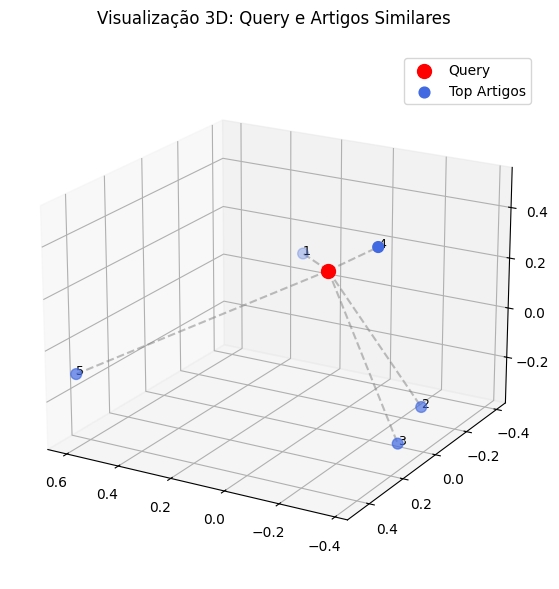


Digite sua busca (ou 'sair' para encerrar): lasso linear regression 

🔍 Resultados mais relevantes:



,TITLE,SIMILARITY,ANGLE (°)
0,When is Network Lasso Accurate?,0.501194,59.920951
1,LLASSO: A linear unified LASSO for multicollin...,0.493735,60.413605
2,Generalized Concomitant Multi-Task Lasso for s...,0.469366,62.006828
3,Robust Regression via Mutivariate Regression D...,0.452600,63.089393
4,High-dimensional Linear Regression for Depende...,0.444252,63.624507



🧠 Resumo do artigo mais relevante:

📘 When is Network Lasso Accurate?

  The "least absolute shrinkage and selection operator" (Lasso) method has been
adapted recently for networkstructured datasets. In particular, this network
Lasso method allows to learn graph signals from a small number of noisy signal
samples by using the total variation of a graph signal for regularization.
While efficient and scalable implementations of the network Lasso are
available, only little is known about the conditions on the underlying network
structure which ensure network Lasso to be accurate. By leveraging concepts of
compressed sensing, we address this gap and derive precise conditions on the
underlying network topology and sampling set which guarantee the network Lasso
for a particular loss function to deliver an accurate estimate of the entire
underlying graph signal. We also quantify the error incurred by network Lasso
in terms of two constants which reflect the connectivity of the sampled nodes.

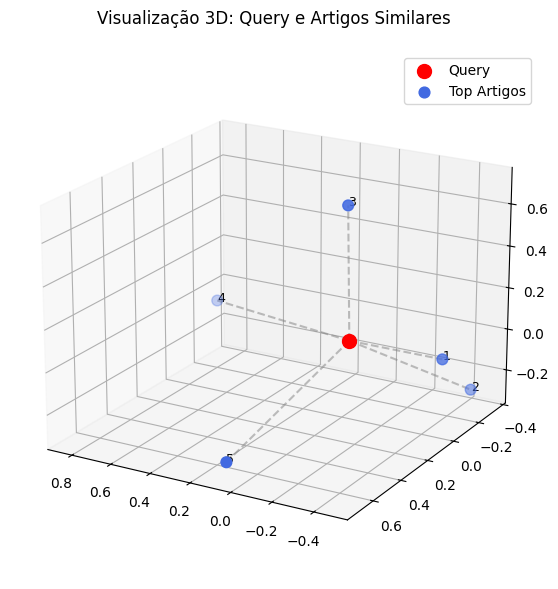


Digite sua busca (ou 'sair' para encerrar): sair
👋 Encerrando busca.


In [12]:
if __name__ == "__main__":
    while True:
        user_query = input("\nDigite sua busca (ou 'sair' para encerrar): ")
        if user_query.lower() in ['sair', 'exit', 'quit']:
            print("👋 Encerrando busca.")
            break
        search_articles(user_query, top_n=5)

